In [228]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

In [2]:
from google.colab import drive


In [288]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [289]:
import xml.etree.ElementTree as ET
import os
import numpy as np
from PIL import Image

# Returns if columns belong to same table or not
def sameTable(ymin_1, ymin_2, ymax_1, ymax_2):
    min_diff = abs(ymin_1 - ymin_2)
    max_diff = abs(ymax_1 - ymax_2)

    if min_diff <= 5 and max_diff <=5:
        return True
    elif min_diff <= 4 and max_diff <=7:
        return True
    elif min_diff <= 7 and max_diff <=4:
        return True
    return False


if __name__ == "__main__":
    directory = '/content/drive/MyDrive/Marmot_data/'
    final_col_directory = '/content/drive/MyDrive/column_mask/'
    final_table_directory = '/content/drive/MyDrive/table_mask/'

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        # Find all the xml files
        if filename.endswith(".xml"):
            filename = filename[:-4]

            # Parse xml file
            tree = ET.parse('/content/drive/MyDrive/Marmot_data/' + filename + '.xml')
            root = tree.getroot()
            size = root.find('size')

            # Parse width
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            # Create grayscale image array
            col_mask = np.zeros((height, width), dtype=np.int32)
            table_mask = np.zeros((height, width), dtype = np.int32)

            got_first_column = False
            i=0
            table_xmin = 10000
            table_xmax = 0

            table_ymin = 10000
            table_ymax = 0

            for column in root.findall('object'):
                bndbox = column.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                col_mask[ymin:ymax, xmin:xmax] = 255
                                
                if got_first_column:
                    if sameTable(prev_ymin, ymin, prev_ymax, ymax) == False:
                        i+=1
                        got_first_column = False
                        table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255
                        
                        table_xmin = 10000
                        table_xmax = 0

                        table_ymin = 10000
                        table_ymax = 0
                        
                if got_first_column == False:
                    got_first_column = True
                    first_xmin = xmin
                    
                prev_ymin = ymin
                prev_ymax = ymax
                
                table_xmin = min(xmin, table_xmin)
                table_xmax = max(xmax, table_xmax)
                
                table_ymin = min(ymin, table_ymin)
                table_ymax = max(ymax, table_ymax)

            table_mask[table_ymin:table_ymax, table_xmin:table_xmax] = 255

            im = Image.fromarray(col_mask.astype(np.uint8),'L')
            im.save(final_col_directory + filename + ".jpeg")

            im = Image.fromarray(table_mask.astype(np.uint8),'L')
            im.save(final_table_directory + filename + ".jpeg")

In [290]:
list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/Marmot_data/*.xml')

# list_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/datasets/flipkart_grid/Marmot_data/*.xml')

In [291]:
img_height, img_width, channels= 256, 256,3

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_bmp(img, channels=3)
  #print("done")
  # resize the image to the desired size
  #img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGRA2BGR)
    #convert the image from RGBA2RGB
  return tf.image.resize(img, [img_height, img_width])
 

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])
def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')

  mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')
  print("done1")
  print(file_path)
  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')
  print(table_mask_file_path)
  #tf.image.decode_bmp()
  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img, {"table_output" : table_mask, "column_output" : column_mask }

In [292]:
dataset= list_ds.map(process_path)

DATASET_SIZE = len(list(list_ds))
print(DATASET_SIZE)
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


done1
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)
494
done1
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)
done1
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace_2:0", shape=(), dtype=string)


In [293]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

done
(256, 256, 3)


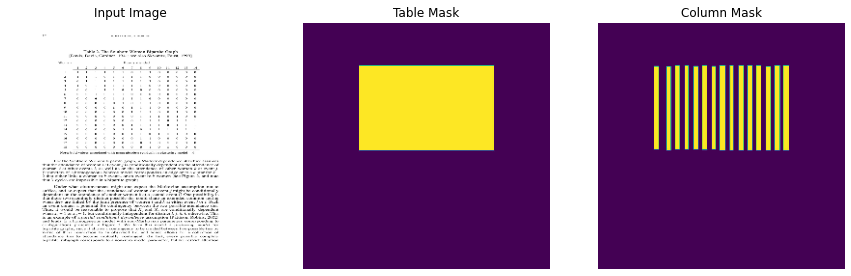

done
(256, 256, 3)


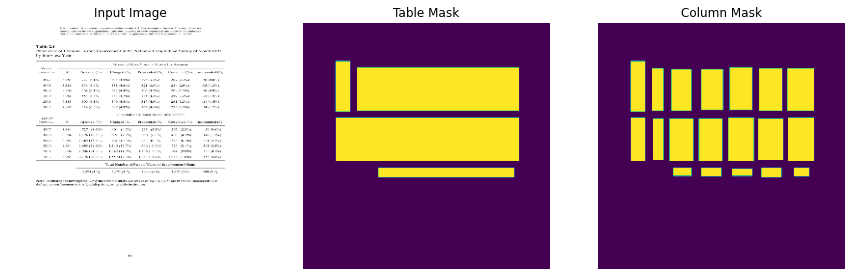

In [294]:
for image, mask in train.take(2):
  print("done")
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output'], mask['column_output']])

In [295]:
class TableNet:
  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='table_output') 
    
    x = last(x)

    return x

  @staticmethod
  def build_column_decoder(inputs, pool3, pool4):
    
    x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
    x = Dropout(0.8, name='block7_dropout_column')(x)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='column_output') 
    
    x = last(x)

    return x  

  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build():
    inputShape = (256, 256, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TableNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
    column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(			
              inputs=inputs,
			        outputs=[table_mask, column_mask],
			        name="tablenet")
    
    return model

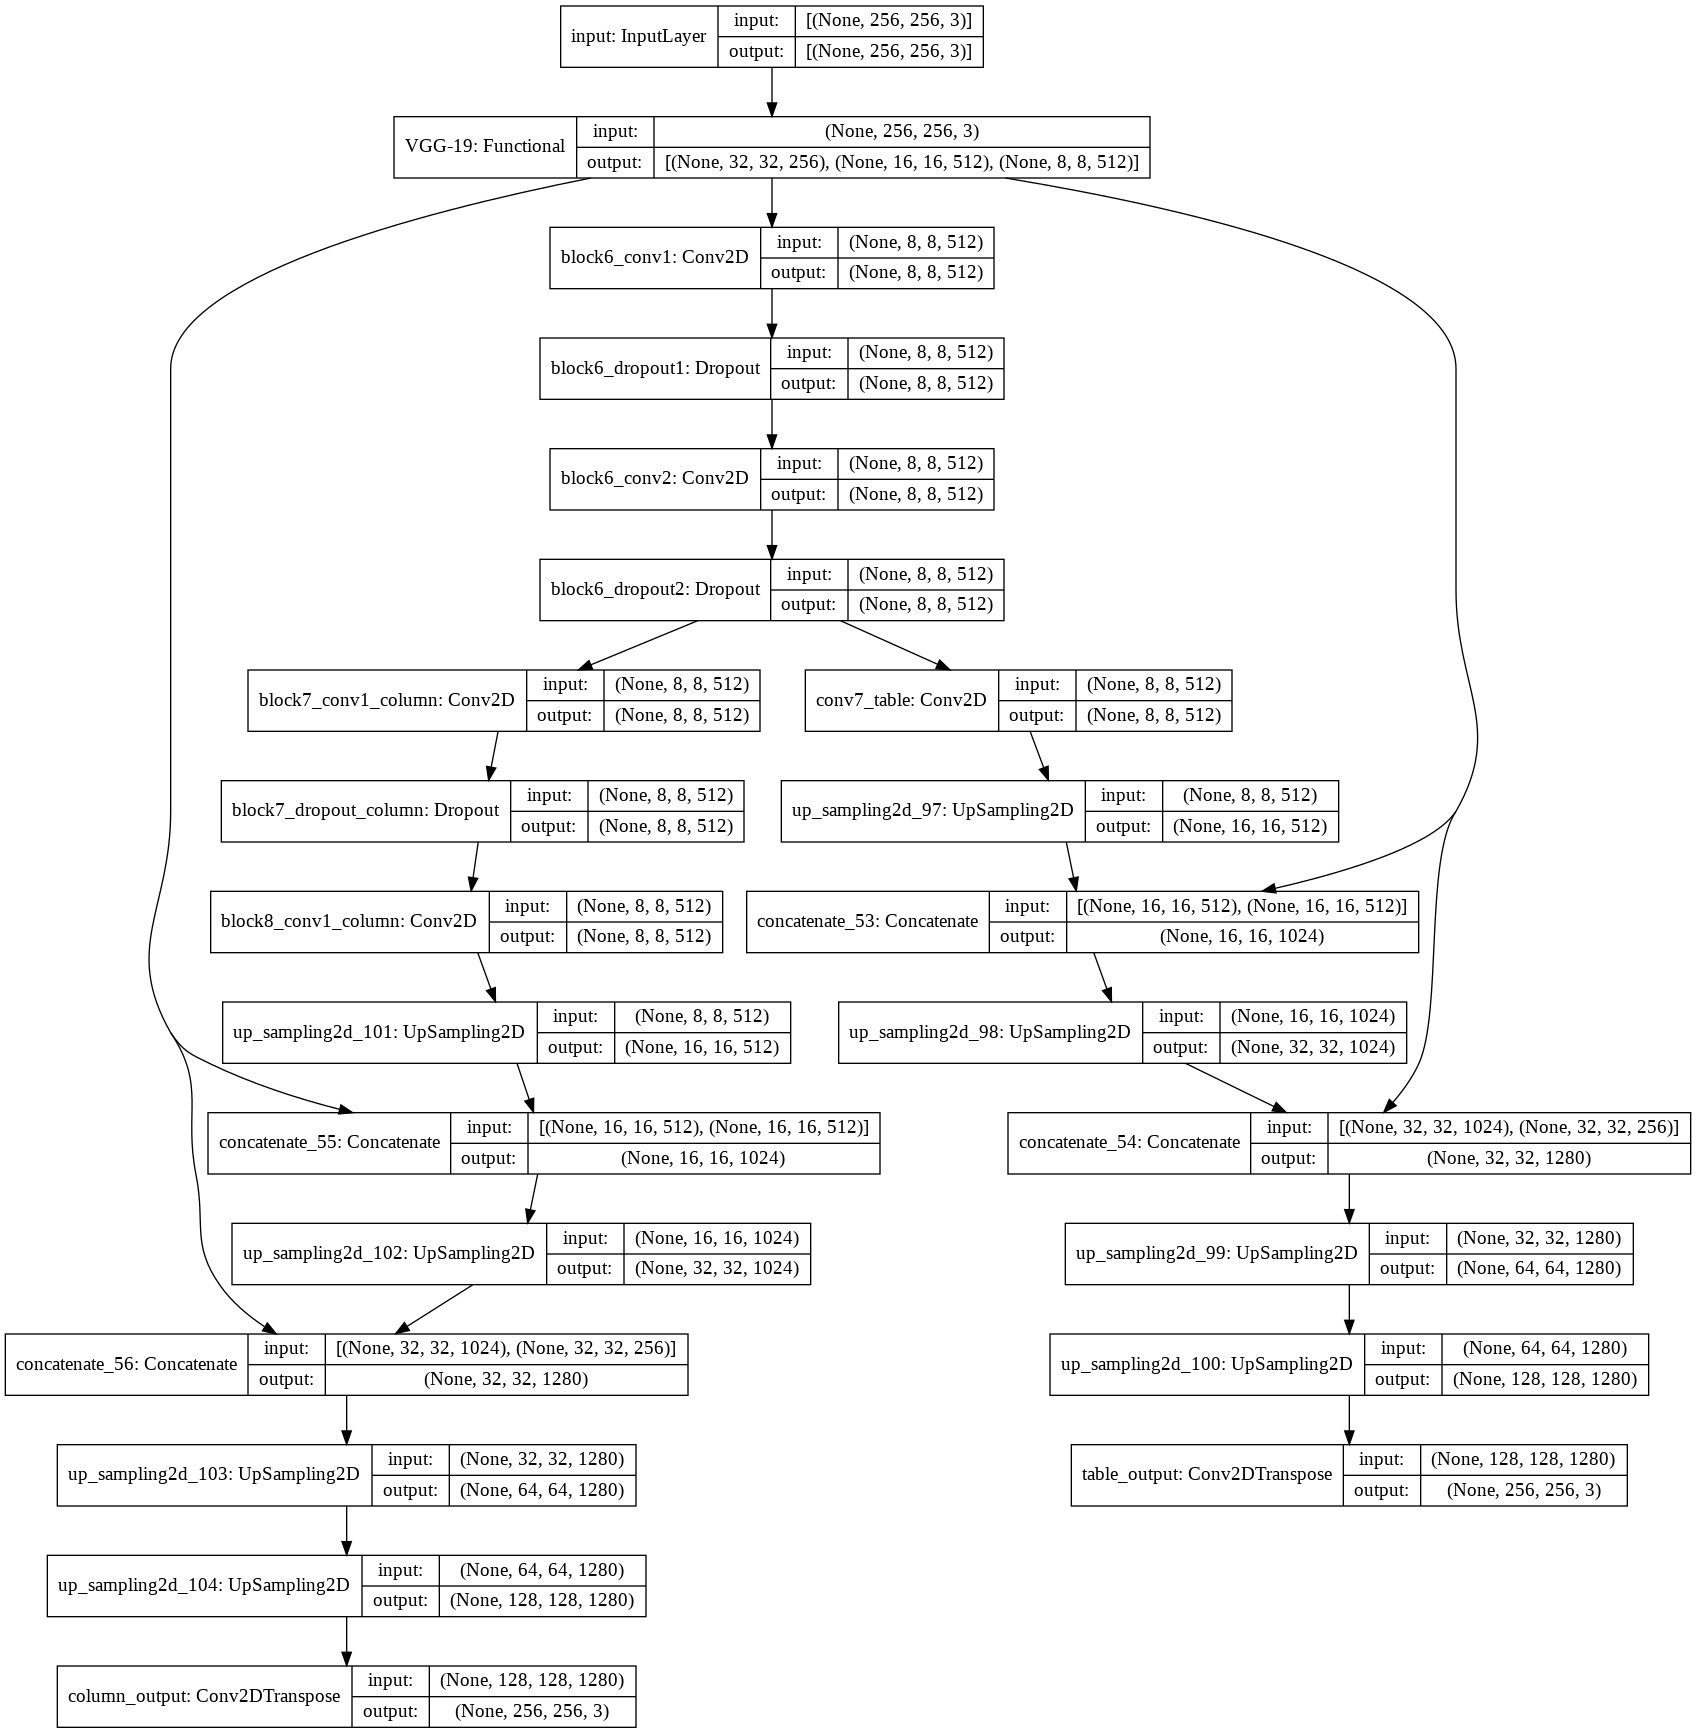

In [296]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [297]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [298]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


In [312]:
count=0;
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']
  count=count+1
print(count)
def show_predictions(dataset, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      display([image[0], table_mask, column_mask])
  else:
    print("here")
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display([sample_image[0], table_mask, column_mask])

def prediction(image):
    pred_mask1, pred_mask2 = model.predict(image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
    display([image, table_mask, column_mask])

1


1/1 [==============================] - 1s 901ms/step


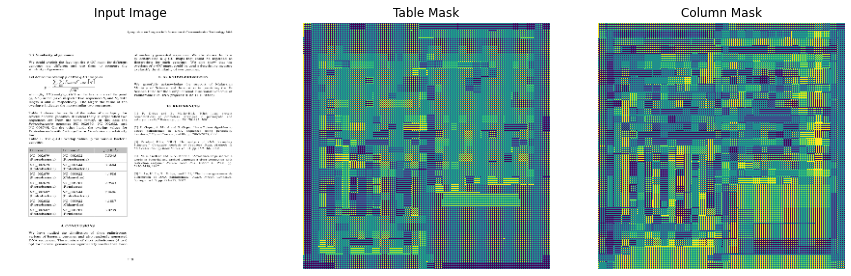

In [302]:
show_predictions(test_dataset)

In [301]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )



In [303]:
EPOCHS = 5000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint])

TypeError: ignored

1/1 [==============================] - 1s 869ms/step


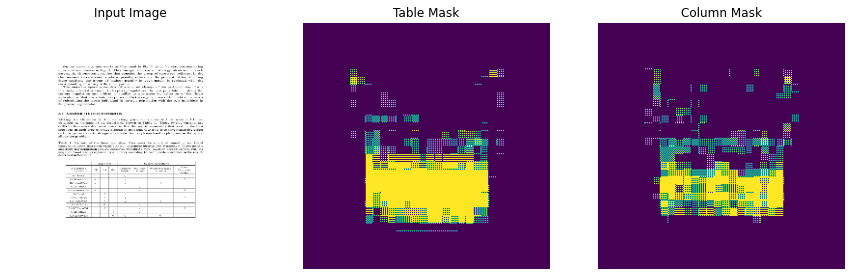

1/1 [==============================] - 1s 856ms/step


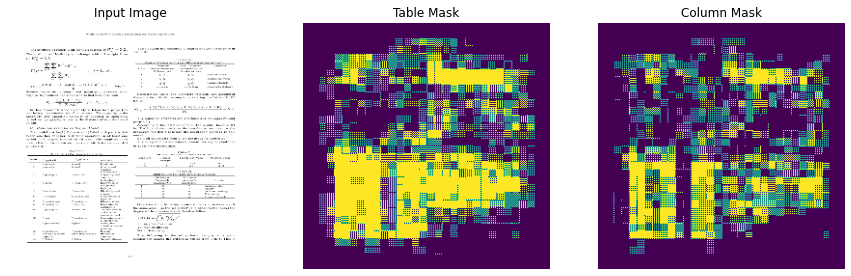

1/1 [==============================] - 1s 890ms/step


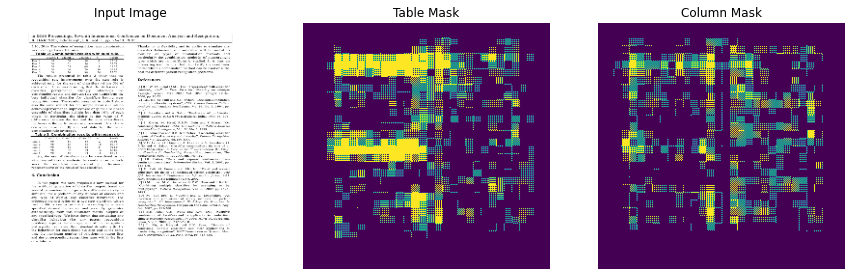

1/1 [==============================] - 1s 898ms/step


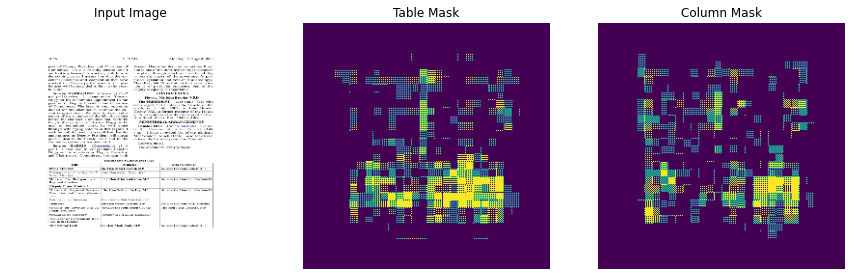

1/1 [==============================] - 1s 881ms/step


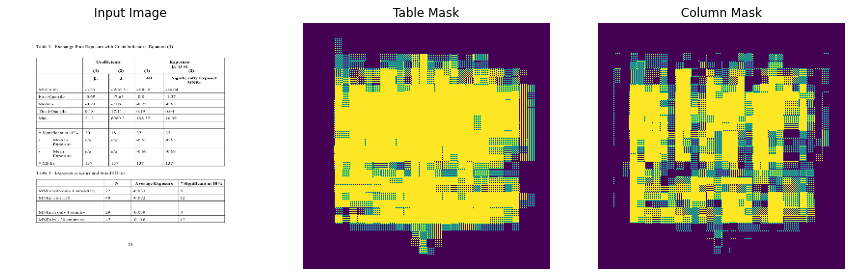

In [304]:
show_predictions(test_dataset, 5)

In [305]:
model.save('model_table1')

INFO:tensorflow:Assets written to: model_table1/assets


In [308]:
!zip -r modeltable1.zip model_table1/

  adding: model_table1/ (stored 0%)
  adding: model_table1/variables/ (stored 0%)
  adding: model_table1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_table1/variables/variables.index (deflated 73%)
  adding: model_table1/saved_model.pb (deflated 91%)
  adding: model_table1/keras_metadata.pb (deflated 95%)
  adding: model_table1/assets/ (stored 0%)


In [309]:
!cp modeltable1.zip '/content/drive/MyDrive/Marmot_data/'